# Productivity prediction

Dataset consists of 1197 observations of details of productivity in a company in the Garment Industry.
It is avaiable to download here: https://www.kaggle.com/ishadss/productivity-prediction-of-garment-employees
<br><br>
Columns description:

01 date : Date in MM-DD-YYYY <br>
02 day : Day of the Week<br>
03 quarter : A portion of the month. A month was divided into four quarters<br>
04 department : Associated department with the instance<br>
05 teamno : Associated team number with the instance 06 noofworkers : Number of workers in each team <br>
07 noofstylechange : Number of changes in the style of a particular product<br>
08 targetedproductivity : Targeted productivity set by the Authority for each team for each day.<br>
09 smv : Standard Minute Value, it is the allocated time for a task <br>
10 wip : Work in progress. Includes the number of unfinished items for products <br>
11 overtime : Represents the amount of overtime by each team in minutes<br>
12 incentive : Represents the amount of financial incentive (in BDT) that enables or motivates a particular course of action.<br>
13 idletime : The amount of time when the production was interrupted due to several reasons <br>
14 idlemen : The number of workers who were idle due to production interruption<br>
15 actual_productivity : The actual % of productivity that was delivered by the workers. It ranges from 0-1.<br>

### 1. Data preparation

In [1]:
# import packages
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import feature_selection
import warnings
from sklearn import metrics
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import KFold
from sklearn import neighbors
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.svm import SVC
import pickle
import gc
import math
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
%matplotlib inline

In [2]:
###### Initial preparation of data ######
# import data
df = pd.read_csv("garments_worker_productivity.csv",dtype={"team":str, "no_of_style_change":str, 
                                                           "idle_men":int})
#create explanatory variable
df.loc[df['targeted_productivity'] > df['actual_productivity'], 'target'] = 0
df.loc[df['targeted_productivity'] <= df['actual_productivity'], 'target'] = 1
#fix issue with dates - extract only months
df["date"] = df["date"].str.extract(r'(\w+)/', expand=False)
df = df.rename(columns={"date": "month"})
# quarter is not needed, as we only have 3 months in data and also column has wrong values
del df['quarter']
#we need to strip department column from white spaces
df.department = df.department.str.strip()

In [3]:
df.isna().sum(axis = 0)

month                      0
department                 0
day                        0
team                       0
targeted_productivity      0
smv                        0
wip                      506
over_time                  0
incentive                  0
idle_time                  0
idle_men                   0
no_of_style_change         0
no_of_workers              0
actual_productivity        0
target                     0
dtype: int64

We can see that for wip variable there are a lot of missing data so, we decide to remove it. 

In [4]:
del df['wip']

In [5]:
#descriptive statistics
df.describe()

,targeted_productivity,smv,over_time,incentive,idle_time,idle_men,no_of_workers,actual_productivity,target
count,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,0.729632,15.062172,4567.460317,38.210526,0.730159,0.369256,34.609858,0.735091,0.730994
std,0.097891,10.943219,3348.823563,160.182643,12.709757,3.268987,22.197687,0.174488,0.443628
min,0.070000,2.900000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705,0.000000
25%,0.700000,3.940000,1440.000000,0.000000,0.000000,0.000000,9.000000,0.650307,0.000000
50%,0.750000,15.260000,3960.000000,0.000000,0.000000,0.000000,34.000000,0.773333,1.000000
75%,0.800000,24.260000,6960.000000,50.000000,0.000000,0.000000,57.000000,0.850253,1.000000
max,0.800000,54.560000,25920.000000,3600.000000,300.000000,45.000000,89.000000,1.120437,1.000000


In [6]:
# Decoding incentive to 3 levels
df.loc[(df['incentive'] == 0) , "incentive_categorized"  ]  = "0"
df.loc[(df['incentive'] > 0) & ((df['incentive']) <= 1000 ) , "incentive_categorized" ]  = "1"
df.loc[(df['incentive'] > 1000) , "incentive_categorized" ]  = "2"
# Then delete the incentive variable
del df["incentive"]

In [7]:
# Decoding idle_time to 2 levels
df.loc[(df['idle_time'] == 0) , "idle_time_categorized"  ]  = "0"
df.loc[(df['idle_time']) > 0 , "idle_time_categorized" ]  = "1"
# Then delete the idle_time variable
del df["idle_time"]

In [8]:
# Decoding idle_men to 2 levels
df.loc[(df['idle_men'] == 0) , "idle_men_categorized"  ]  = "0"
df.loc[(df['idle_men']) > 0 , "idle_men_categorized" ]  = "1"
# Then delete the idle_men variable
del df["idle_men"]

In [9]:
del df["idle_men_categorized"]

### 2. Feature selection

In [10]:
#Prepare list of numeric and categorical columns 
levCols = []
numCols = []
for col in df.columns:
    if df[col].dtype==object:
        levCols.append(col)
    else:
        numCols.append(col)

#delete vars, which were used to create the dependent variable
numCols.remove("targeted_productivity")
numCols.remove("actual_productivity")

features = numCols + levCols
# target is dependent variable, so we delete it
features.remove("target")
numCols.remove("target")

#### Mutual information

In [11]:
# Firstly, we need to encode the str into int variables to obtain corelation metrics
df_copy = df.copy()
le = preprocessing.LabelEncoder()
for col in levCols:
    df_copy[col] = le.fit_transform(df_copy[col])

warnings.simplefilter(action='ignore', category=FutureWarning)

# Print correlation metrics
minfos=[]
for var in levCols:
    print("\n", var)
    print("Pearson", stats.pearsonr(df_copy["target"], df_copy[var]))
    # Random state set to 0 for Mutual Info
    print("Mutual info", feature_selection.mutual_info_classif(df_copy[var].values.reshape(-1,1),df_copy["target"].values, random_state = 0))
    minfos.append(feature_selection.mutual_info_classif(df_copy[var].values.reshape(-1,1),df_copy["target"].values, random_state=0))
    print("Chi2", feature_selection.chi2(df_copy[var].values.reshape(-1,1),df_copy["target"].values))
    print("Anova", feature_selection.f_classif(df_copy[var].values.reshape(-1,1),df_copy["target"].values))

imp = list(zip(minfos, levCols))
imp.sort(reverse=True)
imp


 month
Pearson (-0.057643560443521244, 0.046162074399216914)
Mutual info [0.01927889]
Chi2 (array([3.04161998]), array([0.08115489]))
Anova (array([3.984045], dtype=float32), array([0.04615975], dtype=float32))

 department
Pearson (0.25888637532281716, 8.775348222054219e-20)
Mutual info [0.01963103]
Chi2 (array([33.9132106]), array([5.76260863e-09]))
Anova (array([85.84513], dtype=float32), array([8.774773e-20], dtype=float32))

 day
Pearson (-0.009713387050659699, 0.7370838757260346)
Mutual info [0.00737069]
Chi2 (array([0.13087163]), array([0.71753001]))
Anova (array([0.1126998], dtype=float32), array([0.7371501], dtype=float32))

 team
Pearson (-0.14742253143349449, 3.0044716314587723e-07)
Mutual info [0.02188792]
Chi2 (array([57.09675386]), array([4.14889915e-14]))
Anova (array([26.548443], dtype=float32), array([3.0044117e-07], dtype=float32))

 no_of_style_change
Pearson (0.006259942235053839, 0.8287107527834078)
Mutual info [0]
Chi2 (array([0.05705217]), array([0.81121727]))
A

[(array([0.07920106]), 'incentive_categorized'),
 (array([0.02188792]), 'team'),
 (array([0.01963103]), 'department'),
 (array([0.01927889]), 'month'),
 (array([0.00737069]), 'day'),
 (array([0]), 'no_of_style_change'),
 (array([0]), 'idle_time_categorized')]

In [12]:
warnings.simplefilter(action='ignore', category=FutureWarning)
minfos=[]
for var in numCols:
    print(var, " Mutual info", feature_selection.mutual_info_regression(df_copy[var].astype(float).values.reshape(-1,1),df_copy["target"].astype(float).values, random_state =  0))
    minfos.append(feature_selection.mutual_info_regression(df_copy[var].astype(float).values.reshape(-1,1),df_copy["target"].astype(float).values, random_state =  0))
# We can sort recorded values
imp = list(zip(minfos, numCols))
imp.sort(reverse=True)
imp

smv  Mutual info [0.134211]
over_time  Mutual info [0.03991998]
no_of_workers  Mutual info [0.05295754]


[(array([0.134211]), 'smv'),
 (array([0.05295754]), 'no_of_workers'),
 (array([0.03991998]), 'over_time')]

In [13]:
# Firstly we need to append back target to our variables
numCols.append("target")
# Binarization of nominal variables along with target variable
dummLev = pd.get_dummies(df[levCols], drop_first = True)
df_dummy = pd.concat([df[numCols], dummLev], axis=1)
# And remove target from numCols to standarize the explanatory variables
numCols.remove("target")
# Let's standarize our results
df_dummy[numCols] = df_dummy[numCols].apply(lambda x: (x-x.mean())/x.std())

In [14]:
# Gather all column names once again after binarization
features = df_dummy.columns.tolist()
features.remove("target")

In [15]:
# Now lets try logistic regression
aucs=[]
for var in features:
    mod = sm.GLM.from_formula(formula="target ~ " + var, data=df_dummy, family=sm.families.Binomial())
    res = mod.fit()
    probs = res.predict()
    aucs.append(metrics.roc_auc_score(df_dummy["target"].values, probs))

print("\n", "--------------", "\n")
imp = list(zip(aucs, features))
imp.sort(reverse=True)
imp


 -------------- 



[(0.727664596273292, 'incentive_categorized_1'),
 (0.6744081632653061, 'no_of_workers'),
 (0.6441987577639751, 'department_sweing'),
 (0.6408731144631765, 'over_time'),
 (0.6348127772848269, 'smv'),
 (0.5654906832298137, 'month_2'),
 (0.5418012422360249, 'team_8'),
 (0.5309192546583852, 'team_3'),
 (0.530111801242236, 'team_7'),
 (0.524360248447205, 'day_Thursday'),
 (0.5225838509316769, 'team_12'),
 (0.5199503105590062, 'day_Sunday'),
 (0.5196397515527951, 'team_4'),
 (0.5194534161490683, 'idle_time_categorized_1'),
 (0.5127950310559006, 'team_9'),
 (0.5121366459627329, 'team_6'),
 (0.5107701863354037, 'day_Tuesday'),
 (0.5092049689440994, 'no_of_style_change_1'),
 (0.5091428571428571, 'day_Saturday'),
 (0.5085590062111801, 'month_3'),
 (0.5083975155279503, 'day_Wednesday'),
 (0.506583850931677, 'team_10'),
 (0.5061118012422361, 'no_of_style_change_2'),
 (0.5049316770186335, 'team_2'),
 (0.5028198757763975, 'team_11'),
 (0.5013913043478261, 'incentive_categorized_2'),
 (0.500037267080

In [16]:
# Choose approperiate variables
chosen_vars = []
for auc,var in imp:
    if auc>= 0.51:
        chosen_vars.append(var)
        chosen_vars

### 3. Modelling

#### 3.1. Logistic regression model

In [17]:
all_columns = "+".join(chosen_vars)
my_formula = "target ~" + all_columns
my_formula # formula used in code for logit model

'target ~incentive_categorized_1+no_of_workers+department_sweing+over_time+smv+month_2+team_8+team_3+team_7+day_Thursday+team_12+day_Sunday+team_4+idle_time_categorized_1+team_9+team_6+day_Tuesday'

In [18]:
trainRes = []
valRes = []
indices = []
predictions = []
kf = KFold(n_splits=6, shuffle=True,random_state = 0)

for train, test in kf.split(df_dummy.index.values):
    mod = sm.GLM.from_formula(formula=my_formula, data=df_dummy.iloc[train], family=sm.families.Binomial())
    res = mod.fit()
    predsTrain = res.predict()
    preds = res.predict(df_dummy.iloc[test])
    predictions.append(preds.tolist().copy())
    trainRes.append(roc_auc_score(df_dummy.iloc[train].target, predsTrain))
    valRes.append(roc_auc_score(df_dummy.iloc[test].target, preds))
    indices.append(test.tolist().copy())
print("Train AUC:", np.mean(trainRes), "Valid AUC:", np.mean(valRes))

Train AUC: 0.8253904212860235 Valid AUC: 0.8123012901332656


In [19]:
logistic_regression = {
    "name":"Logistic regression: ",
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

#### 3.2. SVM

In [20]:
kf = KFold(n_splits=5, random_state=0, shuffle =True)
indices = []
predictions = []
aucs = []
aucsT = []
clf = SVC(C = 0.5, cache_size=500, kernel= 'rbf', 
          max_iter=-1, probability=True,
          tol=0.001, verbose=False, random_state = 0)
for train, test in kf.split(df_dummy.index.values):
    clf.fit(df_dummy.iloc[train][chosen_vars].values, df_dummy.iloc[train]["target"].values)
    prob = clf.predict_proba(df_dummy.iloc[test][chosen_vars])
    predictions.append(prob[:,1].tolist())
    aucs.append(metrics.roc_auc_score(df_dummy.iloc[test]["target"].values, prob[:,1])) 
    indices.append(test.tolist())
    prob2 = clf.predict_proba(df_dummy.iloc[train][chosen_vars])
    aucsT.append(metrics.roc_auc_score(df_dummy.iloc[train]["target"].values, prob2[:,1]))
print("Train set: ", np.mean(aucsT))
print("Validation set: ", np.mean(aucs))

Train set:  0.8592479477314626
Validation set:  0.8180569847757548


In [21]:
SVM = {
    "name":"SVM: ",
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

#### 3.3. KNN

In [22]:
kf = KFold(n_splits=10, random_state=0, shuffle=True)
probs = []
indices = []
aucs = []
bacc = []
accs = []
n_neighbors = 24
clf = neighbors.KNeighborsClassifier(n_neighbors, n_jobs=-1, p=1)
for train, test in kf.split(df_dummy.index.values):
    clf.fit(df_dummy.iloc[train][chosen_vars].values, df_dummy.iloc[train]["target"].values)
    prob = clf.predict_proba(df_dummy.iloc[test][chosen_vars].values)
    probs.append(prob[:,1].tolist())
    indices.append(test.tolist())
    aucs.append(metrics.roc_auc_score(df_dummy.iloc[test]["target"].values, prob[:,1]))
    accs.append(metrics.accuracy_score(df_dummy.iloc[test]["target"].values, (prob[:,1]>0.50).astype(int)))
print('AUC: ', np.mean(aucs))
print('ACC: ',np.mean(accs))


AUC:  0.8113199102539937
ACC:  0.775203081232493


In [23]:
KNN = {
    "name":"KNN: ",
    "predictions":probs.copy(),
    "indices":indices.copy(),
}

### 4. Imbalanced dataset

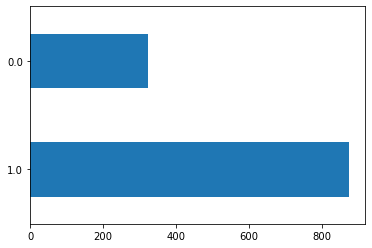

In [24]:
df_dummy['target'].value_counts().plot(kind='barh')

#### 4.1. Logistic regression

##### 4.1.1. SMOTE

In [25]:
# Oversampling in cross-validation
kf = KFold(n_splits=6, shuffle=True, random_state=0)
probs = []
auc = []
aucT = []
indices = []
smt = SMOTE(sampling_strategy=0.5, random_state=0)

for train, test in kf.split(df_dummy.index.values):
    # Extract training & validation data 
    X_train_fold, y_train_fold = df_dummy.iloc[train][chosen_vars].values, df_dummy.iloc[train]["target"].values
    X_val_fold, y_val_fold = df_dummy.iloc[test][chosen_vars].values, df_dummy.iloc[test]["target"].values
    
    # Upsample the training data only
    X_train_fold_upsample, y_train_fold_upsample = smt.fit_resample(X_train_fold,
                                                                       y_train_fold)
    # Create new joined dataset
    df_upsampled = pd.DataFrame(X_train_fold_upsample, columns=chosen_vars)
    df_upsampled["target"] = y_train_fold_upsample
    # Prepare model0.811
    mod = sm.GLM.from_formula(formula=my_formula, data=df_upsampled, family=sm.families.Binomial())
    # Fit the model based on the upsampled datat
    res = mod.fit()
    # Predict on untouched (not upsampled) validations set
    predsTrain = res.predict()
    predsValid = res.predict(df_dummy.iloc[test])
    probs.append(predsValid.tolist())
    indices.append(test.tolist())
    auc.append(metrics.roc_auc_score(y_train_fold_upsample, predsTrain))
    aucT.append( metrics.roc_auc_score(y_val_fold, predsValid))
    
print("Train AUC:", np.mean(auc),
      "Valid AUC:", np.mean(aucT))

Train AUC: 0.8320834586821094 Valid AUC: 0.8115126927321875


In [26]:
logistic_regression_SMOTE = {
    "name":"logistic_regression_SMOTE: ",
    "predictions":probs.copy(),
    "indices":indices.copy(),
}

##### 4.1.2. ADASYN

In [27]:
# Oversampling in cross-validation
kf = KFold(n_splits=6, shuffle=True, random_state=0)
probs = []
auc = []
aucT = []
indices = []
ada = ADASYN(sampling_strategy=0.5, random_state=0)

for train, test in kf.split(df_dummy.index.values):
    # Extract training & validation data 
    X_train_fold, y_train_fold = df_dummy.iloc[train][chosen_vars].values, df_dummy.iloc[train]["target"].values
    X_val_fold, y_val_fold = df_dummy.iloc[test][chosen_vars].values, df_dummy.iloc[test]["target"].values
    
    # Upsample the training data only
    X_train_fold_upsample, y_train_fold_upsample = ada.fit_resample(X_train_fold,
                                                                       y_train_fold)
    # Create new joined dataset
    df_upsampled = pd.DataFrame(X_train_fold_upsample, columns=chosen_vars)
    df_upsampled["target"] = y_train_fold_upsample
    # Prepare model
    mod = sm.GLM.from_formula(formula=my_formula, data=df_upsampled, family=sm.families.Binomial())
    # Fit the model based on the upsampled datat
    res = mod.fit()
    # Predict on untouched (not upsampled) validations set
    predsTrain = res.predict()
    predsValid = res.predict(df_dummy.iloc[test])
    probs.append(predsValid.tolist())
    indices.append(test.tolist())
    auc.append(metrics.roc_auc_score(y_train_fold_upsample, predsTrain))
    aucT.append( metrics.roc_auc_score(y_val_fold, predsValid))
print("Train AUC:", np.mean(auc),
      "Valid AUC:", np.mean(aucT))

Train AUC: 0.7960326742955209 Valid AUC: 0.8068185505242663


In [28]:
logistic_regression_ADASYN = {
    "name":"logistic_regression_ADASYN: ",
    "predictions":probs.copy(),
    "indices":indices.copy(),
}

### 4.2. SVM

##### 4.2.1. SMOTE

In [29]:
# Oversampling in cross-validation
kf = KFold(n_splits=5, random_state=0, shuffle =True)
aucs = []
aucsT = []
clf = SVC(C = 0.5, cache_size=500, kernel= 'rbf',
          max_iter=-1, probability=True,
          tol=0.001, verbose=False, random_state = 0)
smt = SMOTE(sampling_strategy=0.5, random_state=0)
probs = []
indices = []

for train, test in kf.split(df_dummy.index.values):
    # Extract training & validation data 
    X_train_fold, y_train_fold = df_dummy.iloc[train][chosen_vars].values, df_dummy.iloc[train]["target"].values
    X_val_fold, y_val_fold = df_dummy.iloc[test][chosen_vars].values, df_dummy.iloc[test]["target"].values
    
    # Upsample the training data only
    X_train_fold_upsample, y_train_fold_upsample = smt.fit_resample(X_train_fold,
                                                                       y_train_fold)
    # Fit the model based on the upsampled datat
    clf.fit(X_train_fold_upsample, y_train_fold_upsample)
    # Predict on untouched (not upsampled) validations set
    prob = clf.predict_proba(X_val_fold)
    probs.append(prob[:,1].tolist())
    indices.append(test.tolist())
    aucs.append(metrics.roc_auc_score(y_val_fold, prob[:,1]))
    accs.append(metrics.accuracy_score(y_val_fold, (prob[:,1]>0.50).astype(int)))
print('AUC: ', np.mean(aucs))
print('ACC: ',np.mean(accs))

AUC:  0.8238690723110904
ACC:  0.7816416636389564


In [30]:
SVM_SMOTE = {
    "name":"SVM_SMOTE: ",
    "predictions":probs.copy(),
    "indices":indices.copy(),
}

##### 4.2.2. ADASYN

In [31]:
# Oversampling in cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=0)
probs = []
indices = []
aucs = []
accs = []
n_neighbors = 24
clf = SVC(C = 0.5, cache_size=500, kernel= 'rbf',
          max_iter=-1, probability=True,
          tol=0.001, verbose=False, random_state = 0)
ada = ADASYN(sampling_strategy=0.5, random_state=0)

for train, test in kf.split(df_dummy.index.values):
    # Extract training & validation data 
    X_train_fold, y_train_fold = df_dummy.iloc[train][chosen_vars].values, df_dummy.iloc[train]["target"].values
    X_val_fold, y_val_fold = df_dummy.iloc[test][chosen_vars].values, df_dummy.iloc[test]["target"].values
    
    # Upsample the training data only
    X_train_fold_upsample, y_train_fold_upsample = ada.fit_resample(X_train_fold,
                                                                       y_train_fold)
    # Fit the model based on the upsampled datat
    clf.fit(X_train_fold_upsample, y_train_fold_upsample)
    # Predict on untouched (not upsampled) validations set
    prob = clf.predict_proba(X_val_fold)
    probs.append(prob[:,1].tolist())
    indices.append(test.tolist())
    aucs.append(metrics.roc_auc_score(y_val_fold, prob[:,1]))
    accs.append(metrics.accuracy_score(y_val_fold, (prob[:,1]>0.50).astype(int)))
print('AUC: ', np.mean(aucs))
print('ACC: ',np.mean(accs))

AUC:  0.8179671724562738
ACC:  0.7936904761904762


In [32]:
SVM_ADASYN = {
    "name":"SVM_ADASYN: ",
    "predictions":probs.copy(),
    "indices":indices.copy(),
}

### 4.3. KNN

##### 4.3.1. SMOTE

In [33]:
# Oversampling in cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=0)
probs = []
indices = []
aucs = []
accs = []
n_neighbors = 24
clf = neighbors.KNeighborsClassifier(n_neighbors, n_jobs=-1, p=1)
smt = SMOTE(sampling_strategy=0.5, random_state=0)

for train, test in kf.split(df_dummy.index.values):
    # Extract training & validation data 
    X_train_fold, y_train_fold = df_dummy.iloc[train][chosen_vars].values, df_dummy.iloc[train]["target"].values
    X_val_fold, y_val_fold = df_dummy.iloc[test][chosen_vars].values, df_dummy.iloc[test]["target"].values
    
    # Upsample the training data only
    X_train_fold_upsample, y_train_fold_upsample = smt.fit_resample(X_train_fold,
                                                                       y_train_fold)
    # Fit the model based on the upsampled datat
    clf.fit(X_train_fold_upsample, y_train_fold_upsample)
    # Predict on untouched (not upsampled) validations set
    prob = clf.predict_proba(X_val_fold)
    probs.append(prob[:,1].tolist())
    indices.append(test.tolist())
    aucs.append(metrics.roc_auc_score(y_val_fold, prob[:,1]))
    accs.append(metrics.accuracy_score(y_val_fold, (prob[:,1]>0.50).astype(int)))
print('AUC: ', np.mean(aucs))
print('ACC: ',np.mean(accs))

AUC:  0.8106720749072005
ACC:  0.773578431372549


In [34]:
KNN_SMOTE = {
    "name":"KNN_SMOTE: ",
    "predictions":probs.copy(),
    "indices":indices.copy(),
}

##### 4.3.2. ADASYN

In [35]:
# Oversampling in cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=0)
probs = []
indices = []
aucs = []
accs = []
preds_KNN_ADASYN = []
n_neighbors = 24
clf = neighbors.KNeighborsClassifier(n_neighbors, n_jobs=-1, p=1)
ada = ADASYN(sampling_strategy=0.5, random_state=0)

for train, test in kf.split(df_dummy.index.values):
    # Extract training & validation data 
    X_train_fold, y_train_fold = df_dummy.iloc[train][chosen_vars].values, df_dummy.iloc[train]["target"].values
    X_val_fold, y_val_fold = df_dummy.iloc[test][chosen_vars].values, df_dummy.iloc[test]["target"].values
    
    # Upsample the training data only
    X_train_fold_upsample, y_train_fold_upsample = ada.fit_resample(X_train_fold,
                                                                       y_train_fold)
    # Fit the model based on the upsampled datat
    clf.fit(X_train_fold_upsample, y_train_fold_upsample)
    # Predict on untouched (not upsampled) validations set
    prob = clf.predict_proba(X_val_fold)
    indices.append(test.tolist().copy())
    aucs.append(metrics.roc_auc_score(y_val_fold, prob[:,1]))
    accs.append(metrics.accuracy_score(y_val_fold, (prob[:,1]>0.50).astype(int)))
    probs.append(prob[:,1].tolist().copy())
print('AUC: ', np.mean(aucs))
print('ACC: ',np.mean(accs))

AUC:  0.8052076453995511
ACC:  0.776890756302521


In [36]:
KNN_ADASYN = {
    "name":"KNN_ADASYN : ",
    "predictions":probs.copy(),
    "indices":indices.copy(),
}

### 5. Visualization of ROC AUC

In [37]:
from sklearn.metrics import roc_curve, roc_auc_score

def plotROCs(results):
    fig, ax = plt.subplots(figsize=(10,9))
        
    for true, pred, label in results:
        fpr, tpr, thresholds = roc_curve(true, pred)
        rocScore = metrics.roc_auc_score(true, pred)
        rocScore = round(rocScore, 6)
        lw = 2
        ax.plot(fpr, tpr, lw=lw, label=f'{label}: {rocScore}')
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([-0.01, 1.0])
    ax.set_ylim([0.0, 1.01])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Receiver operating characteristic - {rocScore}')
    ax.legend(loc="lower right")
    plt.show()

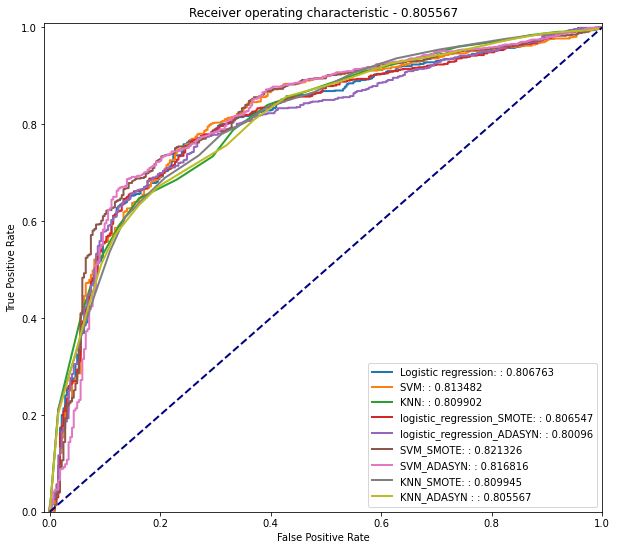

In [38]:
res2plot = []
pred_names = []
true = df_dummy["target"].sort_index()
measures = [logistic_regression, SVM,KNN,logistic_regression_SMOTE,logistic_regression_ADASYN,
           SVM_SMOTE,SVM_ADASYN, KNN_SMOTE, KNN_ADASYN ]
for result in measures:
    # Tworzymy wektor predykcji tworząc serię pandasa, a następnie sortujemy indeks
    pred = pd.Series(sum(result["predictions"], []), index=sum(result["indices"], [])).sort_index()
    pred_names.append(result["name"])
    df_dummy[result["name"]] = pred
    res2plot.append((true, pred, result["name"]))
    
plotROCs(res2plot)

### Ensembling

In [39]:
df_dummy[pred_names].sample(10)

,Logistic regression:,SVM:,KNN:,logistic_regression_SMOTE:,logistic_regression_ADASYN:,SVM_SMOTE:,SVM_ADASYN:,KNN_SMOTE:,KNN_ADASYN :
1056,0.909034,0.794465,0.916667,0.873398,0.880895,0.824207,0.783301,0.916667,0.875000
516,0.740166,0.820603,0.833333,0.703738,0.679290,0.767462,0.752714,0.833333,0.791667
1113,0.964637,0.832513,0.916667,0.963463,0.933461,0.858848,0.823472,0.833333,0.875000
1125,0.433948,0.327668,0.458333,0.400927,0.397819,0.192412,0.251194,0.291667,0.416667
1051,0.671008,0.837480,0.583333,0.591683,0.568351,0.800724,0.757601,0.458333,0.583333
938,0.948363,0.875585,0.958333,0.942518,0.904536,0.865178,0.839754,0.958333,0.958333
980,0.965635,0.882233,0.958333,0.959190,0.939858,0.890886,0.838737,0.958333,0.958333
805,0.447178,0.610691,0.708333,0.359381,0.482164,0.343512,0.517950,0.708333,0.666667
1073,0.653352,0.805671,0.750000,0.620977,0.592176,0.735097,0.747899,0.750000,0.708333
22,0.808759,0.834931,0.750000,0.759090,0.743862,0.855494,0.809037,0.708333,0.708333


In [40]:
print(df_dummy[pred_names].idxmax(axis=1).value_counts())
print(df_dummy[pred_names].idxmin(axis=1).value_counts())

KNN:                            572
SVM:                            260
Logistic regression:            246
SVM_SMOTE:                       61
logistic_regression_SMOTE:       20
logistic_regression_ADASYN:      19
SVM_ADASYN:                       7
KNN_ADASYN :                      6
KNN_SMOTE:                        6
dtype: int64
SVM_ADASYN:                     477
logistic_regression_ADASYN:     176
KNN_SMOTE:                      154
logistic_regression_SMOTE:      136
SVM_SMOTE:                      126
KNN_ADASYN :                     69
SVM:                             46
KNN:                             13
dtype: int64


In [41]:
df_dummy["ENSEMBLING"] = df_dummy[pred_names].mean(axis=1)

In [42]:
res2plot.append((true, df_dummy["ENSEMBLING"].sort_index().tolist(), "ENSEMBLING"))

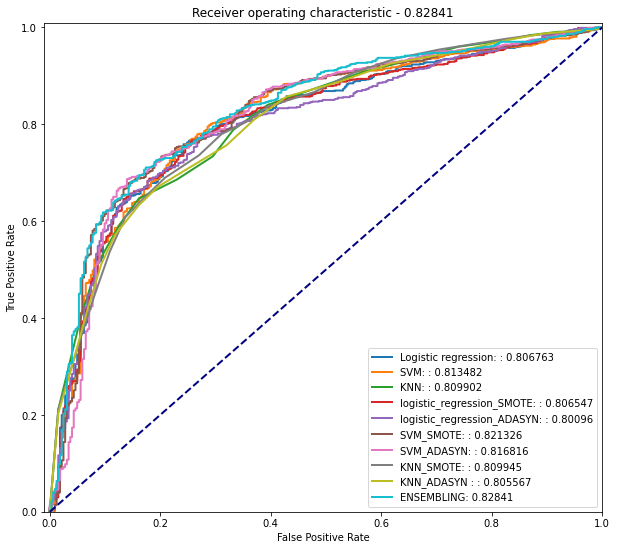

In [43]:
plotROCs(res2plot)